In [2]:
# library to handle data in a vectorized manner
import numpy as np

# library for data analsysis
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# library to handle JSON files
import json

# library to handle requests
import requests
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
# map rendering library
import folium

# scraping library
from bs4 import BeautifulSoup

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Libraries imported.


In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

#get the entire html of the article as a str
text_result = requests.get(url).text
#transform the text to html
html_parsed_result = BeautifulSoup(text_result, 'html.parser')
neightborhood_info_table = html_parsed_result.find('table', class_ = 'wikitable')
neightborhood_rows = neightborhood_info_table.find_all('tr')

#The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
# extract the info ('Postcode', 'Borough', 'Neighbourhood') from the table
neightborhood_info = []
for row in neightborhood_rows:
    info = row.text.split('\n')[1:-1]
    neightborhood_info.append(info)
    
neightborhood_info[0:10]

[['Postcode', 'Borough', 'Neighbourhood'],
 ['M1A', 'Not assigned', 'Not assigned'],
 ['M2A', 'Not assigned', 'Not assigned'],
 ['M3A', 'North York', 'Parkwoods'],
 ['M4A', 'North York', 'Victoria Village'],
 ['M5A', 'Downtown Toronto', 'Harbourfront'],
 ['M5A', 'Downtown Toronto', 'Regent Park'],
 ['M6A', 'North York', 'Lawrence Heights'],
 ['M6A', 'North York', 'Lawrence Manor'],
 ['M7A', "Queen's Park", 'Not assigned']]

In [4]:
#create a Neighborhoods dataframe
neightborhood_info[0][-1] = 'Neighborhood'
neighborhood_df = pd.DataFrame(neightborhood_info[1:], columns=neightborhood_info[0])

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
9,M8A,Not assigned,Not assigned


In [5]:
not_assigned_boroughs = neighborhood_df.index[neighborhood_df['Borough'] == 'Not assigned']
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned']
not_assigned_neighborhoods_and_borough = not_assigned_boroughs & not_assigned_neighborhoods

print('The DataFrame shape is {}'.format(neighborhood_df.shape),'\n')
print('There are:')
print('  {} Postal codes'.format(neighborhood_df['Postcode'].unique().shape[0]))
print('  {} Boroughs'.format(neighborhood_df['Borough'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} Neighborhoods'.format(neighborhood_df['Neighborhood'].unique().shape[0] - 1)) # substract one because "not assigned" doesn't count
print('  {} were not assigned Borough'.format(not_assigned_boroughs.shape[0]))
print('  {} were not assigned Neighborhood'.format(not_assigned_neighborhoods.shape[0]))
print('  {} were not assigned Neighborhood and Borough'.format(not_assigned_neighborhoods_and_borough.shape[0]),'\n')

The DataFrame shape is (288, 3) 

There are:
  180 Postal codes
  11 Boroughs
  208 Neighborhoods
  77 were not assigned Borough
  78 were not assigned Neighborhood
  77 were not assigned Neighborhood and Borough 



In [6]:
#Ignore cells with a borough that is Not assigned
neighborhood_df.drop(neighborhood_df.index[not_assigned_boroughs], inplace=True)
neighborhood_df.reset_index(drop=True, inplace=True)

neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Not assigned
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [7]:
#If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
not_assigned_neighborhoods = neighborhood_df.index[neighborhood_df['Neighborhood'] == 'Not assigned'] 

for idx in not_assigned_neighborhoods:
    neighborhood_df['Neighborhood'][idx] = neighborhood_df['Borough'][idx]
    
neighborhood_df.head(10)

,Postcode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights
5,M6A,North York,Lawrence Manor
6,M7A,Queen's Park,Queen's Park
7,M9A,Etobicoke,Islington Avenue
8,M1B,Scarborough,Rouge
9,M1B,Scarborough,Malvern


In [8]:
#More than one neighborhood can exist in one postal code area.
#combined into one row with the neighborhoods separated with a comma
group = neighborhood_df.groupby('Postcode')
grouped_neighborhoods = group['Neighborhood'].apply(lambda x: "%s" % ', '.join(x))
grouped_boroughs = group['Borough'].apply(lambda x: set(x).pop())
grouped_df = pd.DataFrame(list(zip(grouped_boroughs.index, grouped_boroughs, grouped_neighborhoods)))
grouped_df.columns = ['Postcode', 'Borough', 'Neighborhood']

grouped_df.head(10)

,Postcode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park"
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge"
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [10]:
#in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

coordinates_df = pd.read_csv('https://cocl.us/Geospatial_data') # transform the csv file into a dataframe

print('The coordinates dataframe shape is', coordinates_df.shape)
coordinates_df.head()

The coordinates dataframe shape is (103, 3)


,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
#To add the coordinates to the neighborhood dataframe, a join is performed using the postcodes as keys
postcodes_with_coordinates_df = grouped_df.join(coordinates_df.set_index('Postal Code'), on='Postcode')

postcodes_with_coordinates_df.head(16)

,Postcode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [12]:
#to generate maps to visualize your neighborhoods and how they cluster together
map_toronto = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

#iterate each row of the dataframe
for location in postcodes_with_coordinates_df.itertuples(): 
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-2], location[-1]],
        radius=4,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    folium.Circle(
        radius=500,
        popup=label,
        location=[location[-2], location[-1]],
        color='#87cefa',
        fill=True,
        fill_color='#87cefa'
    ).add_to(map_toronto) 
    
map_toronto

In [13]:
# to make it more fit
import matplotlib.pyplot as plt

X = postcodes_with_coordinates_df[['Longitude', 'Latitude']]

scatter_plot = X.plot.scatter(x='Longitude', 
               y='Latitude',  
               fontsize = 16,
               figsize=(15, 10))

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
scatter_plot.set_title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

<Figure size 1500x1000 with 1 Axes>

In [16]:
#to find closest point
from geopy.distance import great_circle

#function to get the closest postcode pair and the distance using latitude and longitude
def closest_postcode(postcode, postcodes):
    postcode = np.asarray(postcode).reshape(1,-1)
    postcodes = np.asarray(postcodes)
    distances = [great_circle(postcode, point).meters for point in postcodes]
    closest_postcode_index = np.argmin(distances)
    return [round(distances[closest_postcode_index]), closest_postcode_index]

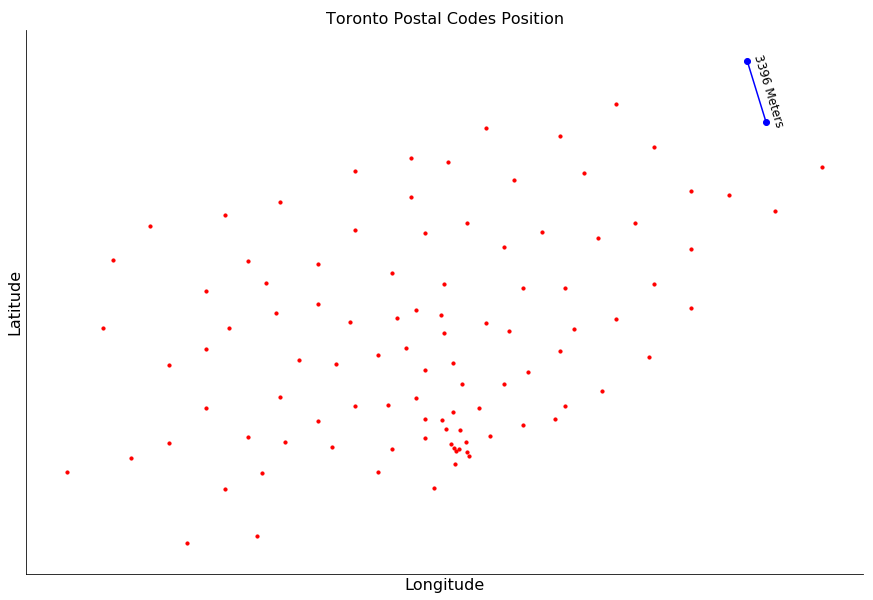

In [17]:
# to find distance
coordinates = postcodes_with_coordinates_df[['Latitude', 'Longitude']]

distance, closest_point_index = closest_postcode(coordinates[:1], coordinates[~coordinates.index.isin([0])])
close_points = X[:1].append(X[closest_point_index+1:closest_point_index+2])
close_points
fig = plt.figure(figsize=(15,10))
scatter_plot = fig.add_subplot(111)
scatter_plot.scatter(X['Longitude'],X['Latitude'], s=10, c='r', marker="o")
scatter_plot.plot(close_points['Longitude'], close_points['Latitude'], c='b', marker="o")

# plt.legend(loc='upper left');
scatter_plot.annotate('{} Meters'.format(distance),
            xy=(.859, .912), xycoords='figure fraction',
            ha='left', va='top', rotation=-73,
            fontsize=12)

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)

plt.xlabel('Longitude', fontsize=16)
plt.ylabel('Latitude', fontsize=16)
plt.title('Toronto Postal Codes Position', fontsize=16)

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

In [19]:
# Add distace into dataframe
from math import isnan

for lat, lng, idx in zip(postcodes_with_coordinates_df['Latitude'], postcodes_with_coordinates_df['Longitude'], postcodes_with_coordinates_df.index):
    distance, closest_point_index = closest_postcode([lat,lng], coordinates[~coordinates.index.isin([idx])])
    postcodes_with_coordinates_df.at[idx,'Distance'] = np.int64(distance//2) #use the half of the disstance to avoid overlapping
    
postcodes_with_coordinates_df.head(10)

,Postcode,Borough,Neighborhood,Latitude,Longitude,Distance
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1698.0
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,1625.0
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1205.0
3,M1G,Scarborough,Woburn,43.770992,-79.216917,913.0
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,913.0
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,1301.0
6,M1K,Scarborough,"East Birchmount Park, Ionview, Kennedy Park",43.727929,-79.262029,1112.0
7,M1L,Scarborough,"Clairlea, Golden Mile, Oakridge",43.711112,-79.284577,1052.0
8,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,1112.0
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,1297.0


In [20]:
#Re-create the map with new markers for Toronto Neighborhoods
map_toronto = folium.Map(location=[43.6532,-79.3832], zoom_start=11)

#iterate each row of the dataframe
for location in postcodes_with_coordinates_df.itertuples(): 
    label = 'Postal Code: {};  Borough: {};  Neighborhoods: {}'.format(location[1], location[2], location[3])
    label = folium.Popup(label, parse_html=True)    
    folium.CircleMarker(
        [location[-3], location[-2]],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto) 
    folium.Circle(
        radius=location[-1],
        popup=label,
        location=[location[-3], location[-2]],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc'
    ).add_to(map_toronto) 
    
map_toronto